In [103]:
import numpy as np
from misc import RK4, ct
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
ppp = 500
periods = 3
seed = 1

def vector_to_matrix(v):
    return np.array([[v[0], v[1]],[v[2], v[3]]])
def matrix_to_vector(v):
    return np.array([v[0,0], v[0,1], v[1,0], v[1,1]])


times = np.arange(0,periods+ dt, dt)
dt = 1/ppp

eta = kwargs.get("eta",1) #efficiency
gamma = kwargs.get("gamma",0.3) # damping (related both to D and to A)
Lambda = kwargs.get("Lambda",0.8) #rate of measurement
omega = kwargs.get("omega",0) #rate of measurement

n = kwargs.get("n",10.0)

A = np.array([[-.5*gamma, omega], [-omega, -0.5*gamma]])
D = np.diag([(gamma*(n+0.5)) + Lambda]*2)
C = np.diag([np.sqrt(4*eta*Lambda)]*2)

cov_in = np.ones((2,2))

xi = lambda cov: np.dot(cov, ct(C)) + ct(D)
def dcovdt(t,cov):
    cov= vector_to_matrix(cov)
    XiCov = xi(cov)
    ev_cov = np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov))
    return matrix_to_vector(ev_cov)

integrate_cov = solve_ivp(dcovdt, y0=matrix_to_vector(cov_in), t_span=(0,times[-1]), t_eval=times, max_step = dt, atol=1, rtol=1)
covs = np.reshape(integrate_cov.y.T, (len(times),2,2))


np.random.seed(seed)

def f(t,x,parameters=None):
    return np.dot(A, x)

xi = lambda cov: np.dot(cov, ct(C)) + ct(D)
def g(t,x,parameters=None):
    gg = np.dot(xi(covs[parameters]),[np.random.normal(), np.random.normal()])
    return gg

states = np.zeros((len(times),2))
states[0] = np.array([0.,0.])
for ind, t in enumerate(tqdm(times[:-1])):
    states[ind+1] = RK4(states[ind], t, dt, f, g, parameters=ind)

diffs = states[1:]-states[:-1]
invsXiCov = np.array([np.linalg.inv(xi(cov)) for cov in covs[:-1]])
CAx = np.einsum('ij,bj->bi',C-A,states[:-1])*dt
signals = np.einsum('bij,bj->bi',invsXiCov,CAx + diffs)



100%|██████████| 1500/1500 [00:00<00:00, 11755.82it/s]


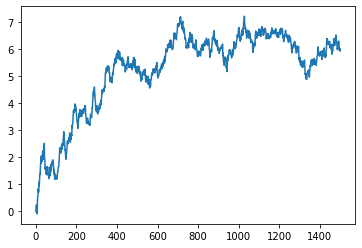

In [105]:
plt.plot(states[:,0][:10000])

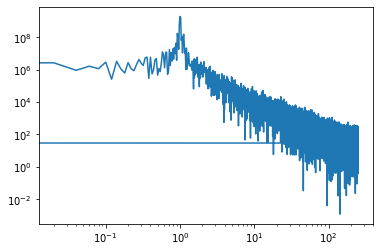

In [95]:
freqs = np.fft.fftfreq(len(signals),d=1/500)
ax = plt.subplot(111)
ax.plot(freqs, np.abs(np.fft.fft(states[:-1][:,1]))**2)
omega = 2*np.pi
period = 2*np.pi/omega
#ax.axvline(1/period)
ax.set_xscale("log")
ax.set_yscale("log")

In [114]:
%load_ext autoreload
%autoreload 2

from misc import *
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
states, covs, signals, [A,C,dt,D] = load_data(periods=50, ppp=500, itraj=1)

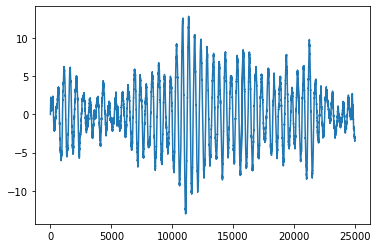

In [122]:
plt.plot(states[:,0])

In [128]:
states, covs, signals, [A,C,dt,D], params = load_data(periods=10000, ppp=500, itraj=1)

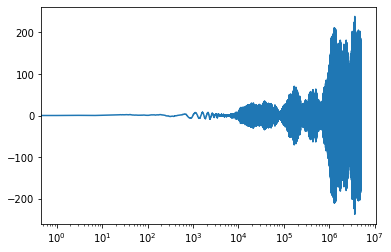

In [130]:
ax= plt.subplot(111)
ax.plot(states[:,0])
ax.set_xscale("log")

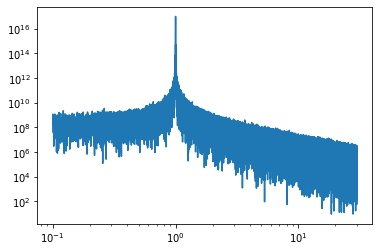

In [154]:
freqs = np.fft.fftfreq(len(signals),d=1/500)
ax = plt.subplot(111)
a=1000#int(len(signals))
b=30000#int(2*len(signals)/3)

ax.plot(freqs[a:b], (np.abs(np.fft.fft(states[:-1][:,1]))**2)[a:b])
omega = 2*np.pi
period = 2*np.pi/omega
#ax.axvline(1/period)
ax.set_xscale("log")
ax.set_yscale("log")

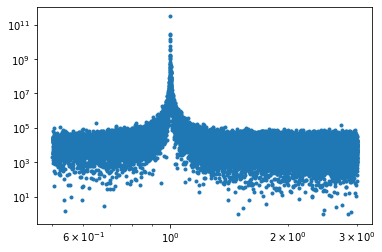

In [159]:
freqs = np.fft.fftfreq(len(signals),d=1/500)
ax = plt.subplot(111)
a=5000#int(len(signals))
b=30000#int(2*len(signals)/3)

ax.plot(freqs[a:b], (np.abs(np.fft.fft(signals[:-1][:,1]))**2)[a:b], '.')
omega = 2*np.pi
period = 2*np.pi/omega
#ax.axvline(1/period)
ax.set_xscale("log")
ax.set_yscale("log")

In [156]:
x = freqs[a:b] 

y  = (np.abs(np.fft.fft(states[:-1][:,1]))**2)[a:b]

In [ ]:
from scipy.optimize import leastsq

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = np.loadtxt('HEMAT_1.dat', unpack=True )
yData = yData / max(yData)

generalWidth = 1

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmin( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - max( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print popt
testData = [ multi_lorentz(x, popt ) for x in xData ]


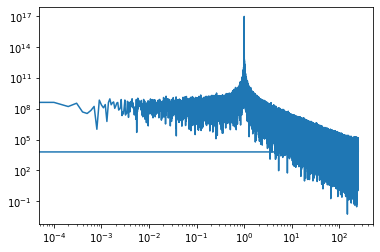

In [131]:
freqs = np.fft.fftfreq(len(signals),d=1/500)
ax = plt.subplot(111)
ax.plot(freqs, np.abs(np.fft.fft(states[:-1][:,1]))**2)
omega = 2*np.pi
period = 2*np.pi/omega
#ax.axvline(1/period)
ax.set_xscale("log")
ax.set_yscale("log")

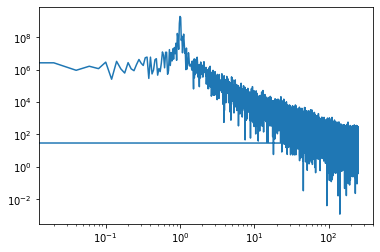

In [123]:
freqs = np.fft.fftfreq(len(signals),d=1/500)
ax = plt.subplot(111)
ax.plot(freqs, np.abs(np.fft.fft(states[:-1][:,1]))**2)
omega = 2*np.pi
period = 2*np.pi/omega
#ax.axvline(1/period)
ax.set_xscale("log")
ax.set_yscale("log")